In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/DiplomadoEPM_2019/master/Modulo3/init.py
from init import init; init(force_download=False)

In [19]:
try:
    %tensorflow_version 2.x
    print ("Using TF2 in Google Colab")
except:
    pass
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from local.lib import mlutils
%matplotlib inline
from sklearn.datasets import *
tf.__version__

'2.1.0'

# `tf.data.Dataset` is TF general facility to deal with any kind of data

- a `tf.data.Dataset` can be fed from many things (imgs, time series, etc.)

- a `tf.data.Dataset` can be fed with structured data using `feature_column`s

- a `feature_column` is a DEFINITION for a column type


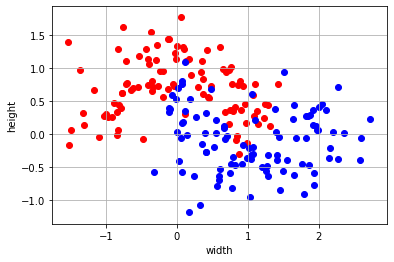

In [53]:
X, y = make_moons(200, noise=.3)

plt.scatter(X[:,0][y==0], X[:,1][y==0], color="red", label="class 0")
plt.scatter(X[:,0][y==1], X[:,1][y==1], color="blue", label="class 1")
plt.xlabel("width"); plt.ylabel("height"); plt.grid();

In [55]:
X[:5]

array([[ 1.81750241,  0.27423903],
       [ 1.85022407,  0.26520457],
       [-0.12396999,  0.67649031],
       [ 1.98325376,  0.05371865],
       [ 2.35652184,  0.01734189]])

### for structured data we build a `tf.data.Dataset` a dictionary spec and labels

In [56]:
train_ds = tf.data.Dataset.from_tensor_slices( ({"width":X[:,0], "height": X[:,1]}, y))

at each call the dataset produces an item

In [76]:
get_first = lambda ds: next(iter(ds))


In [67]:
for i,_ in zip(train_ds, range(3)):
    print ("data", i[0])
    print ("label", i[1])
    print ("--")

data {'width': <tf.Tensor: shape=(), dtype=float64, numpy=1.8175024110356466>, 'height': <tf.Tensor: shape=(), dtype=float64, numpy=0.27423902609716033>}
label tf.Tensor(1, shape=(), dtype=int64)
--
data {'width': <tf.Tensor: shape=(), dtype=float64, numpy=1.8502240677537525>, 'height': <tf.Tensor: shape=(), dtype=float64, numpy=0.2652045712397648>}
label tf.Tensor(1, shape=(), dtype=int64)
--
data {'width': <tf.Tensor: shape=(), dtype=float64, numpy=-0.12396998791629904>, 'height': <tf.Tensor: shape=(), dtype=float64, numpy=0.6764903076563374>}
label tf.Tensor(0, shape=(), dtype=int64)
--


### we can do many things with datasets:
    
- batching
- shuffling
- see https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [77]:
get_first(train_ds.batch(4))


({'width': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([ 1.81750241,  1.85022407, -0.12396999,  1.98325376])>,
  'height': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.27423903, 0.26520457, 0.67649031, 0.05371865])>},
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 1, 0, 1])>)

In [79]:
get_first(train_ds.batch(4).shuffle(buffer_size=20))


({'width': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([ 0.74581902, -0.61135576,  0.34151491,  1.02937987])>,
  'height': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-0.58892489,  0.69373679,  0.93895971, -0.9519615 ])>},
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 0, 0, 1])>)

## Structured datasets can be used in a model by:

- specifying column types with `tf.feature_column`
- using `DenseFeatures` layer

In [151]:
fwidth  = tf.feature_column.numeric_column('width')
fheight = tf.feature_column.numeric_column('height')
feature_columns = [fwidth, fheight]

In [181]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.DenseFeatures(feature_columns, dtype=tf.float64))
model.add(tf.keras.layers.Dense(10, activation="tanh"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

### `.fit` now only needs the batched dataset

- there is no `X` and `y`, since labels are integrated in the dataset

In [182]:
k = model.fit(train_ds.batch(len(X)), epochs=1000, verbose=0)

In [183]:
model.evaluate(train_ds.batch(len(X)))

1/1 [==============================] - 0s 67ms/step - loss: 0.0666 - accuracy: 0.9250


[0.06664033979177475, 0.925]

### all methods now need a batched dataset

- we cannot use `numpy` arrays in memory anymore
- but `tf.data.Datasets` are **very general** (for streaming, etc.)

In [179]:
predict = lambda X: (model.predict(tf.data.Dataset.from_tensor_slices( ({"width":X[:,0], "height": X[:,1]})).batch(len(X)))[:,0]>.5).astype(int)
preds = predict(X)
preds

array([1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1])

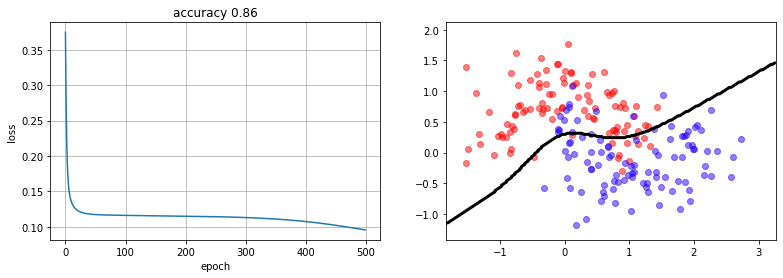

In [180]:
plt.figure(figsize=(13,4))
plt.subplot(121)
plt.plot(k.history["loss"])
plt.xlabel("epoch"); plt.ylabel("loss"); plt.grid();
plt.title("accuracy %.2f"%np.mean(preds==y));
plt.subplot(122)
mlutils.plot_2Ddata_with_boundary(predict, X,y);


### integrating structured datasets into the functional api is somewhat more involved

In [131]:
inputs = {col.name: tf.keras.layers.Input(name=col.name, shape=(), dtype=tf.float64) \
          for col in feature_columns}
features = tf.keras.layers.DenseFeatures(feature_columns, dtype=tf.float64)(inputs)
hidden   = tf.keras.layers.Dense(10, activation="tanh")(features)
outputs  = tf.keras.layers.Dense(1, activation="sigmoid")(hidden)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])


In [147]:
model.fit(train_ds.batch(10), epochs=100, verbose=0)

In [145]:
model.evaluate(train_ds.batch(5))

40/40 [==============================] - 0s 762us/step - loss: 0.0651 - accuracy: 0.9250


[0.0651102327137778, 0.925]

# There are several kinds of `feature_columns` with different options

- you can use `tf.keras.layers.DenseFeatures` directly to inspect their output before using them in a model


### a `numeric_column` (see [doc](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column)) can have a normalizer and a default value

In [199]:
fwidth  = tf.feature_column.numeric_column('width', normalizer_fn=lambda x: (x-np.min(X[:,0]))/(np.max(X[:,0])-np.min(X[:,0])))
fheight = tf.feature_column.numeric_column('height', normalizer_fn=lambda x: (x-np.min(X[:,1]))/(np.max(X[:,1])-np.min(X[:,1])))


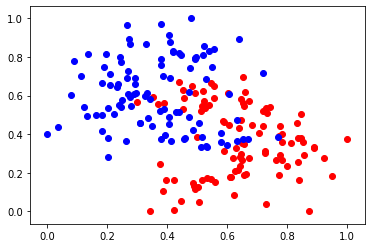

In [200]:
Xt = tf.keras.layers.DenseFeatures([fwidth, fheight], dtype=tf.float64)\
     ({"width":X[:,0], "height": X[:,1]}).numpy()

plt.scatter(Xt[:,0][y==0], Xt[:,1][y==0], color="red", label="class 0")
plt.scatter(Xt[:,0][y==1], Xt[:,1][y==1], color="blue", label="class 1")


### a `bucketized_column` (see [doc](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column)) discretizes continuous data into a one-hot encoding

observe that it takes another `feature_column` as input

here we define 6 buckets (see linearize below) in the [0,1] interval **AFTER** normalization

In [226]:
np.linspace(0,1,5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [233]:
bwidth  = tf.feature_column.bucketized_column(fwidth, boundaries=list(np.linspace(0,1,5)))

In [231]:
Xt = tf.keras.layers.DenseFeatures([bwidth], dtype=tf.float64)\
     ({"width":X[:,0], "height": X[:,1]}).numpy()

observe the assignment from the **original** data

In [232]:
for i,j in zip(X[:10,0], Xt[:10]):
    print ("%5.2f"%i,"-->", j)

 1.82 --> [0. 1.]
 1.85 --> [0. 1.]
-0.12 --> [1. 0.]
 1.98 --> [0. 1.]
 2.36 --> [0. 1.]
 0.10 --> [1. 0.]
 0.35 --> [1. 0.]
-0.01 --> [1. 0.]
-1.37 --> [1. 0.]
 0.07 --> [1. 0.]


we can compose our dataset as we want. Here we keep the original columns and add bucketized ones

In [234]:
bwidth  = tf.feature_column.bucketized_column(fwidth, boundaries=[0.5])
bheight = tf.feature_column.bucketized_column(fheight, boundaries=[0.5])
Xt = tf.keras.layers.DenseFeatures([fwidth, fheight, bwidth, bheight], dtype=tf.float64)\
     ({"width":X[:,0], "height": X[:,1]}).numpy()

In [240]:
for w,h,j in zip(X[:10,0], X[:10,1], Xt[:10]):
    print ("%5.2f, %5.2f"%(w,h),"-->", j.round(5))

 1.82,  0.27 --> [0.49419 1.      0.      0.7869  0.      1.     ]
 1.85,  0.27 --> [0.49113 1.      0.      0.7946  0.      1.     ]
-0.12,  0.68 --> [0.6305  0.      1.      0.33031 1.      0.     ]
 1.98,  0.05 --> [0.41946 1.      0.      0.82589 0.      1.     ]
 2.36,  0.02 --> [0.40713 1.      0.      0.91367 0.      1.     ]
 0.10,  1.29 --> [0.83808 0.      1.      0.38215 1.      0.     ]
 0.35, -0.15 --> [0.34899 1.      0.      0.44203 1.      0.     ]
-0.01,  0.53 --> [0.57956 0.      1.      0.35729 1.      0.     ]
-1.37,  0.97 --> [0.72963 0.      1.      0.03844 1.      0.     ]
 0.07,  0.16 --> [0.45516 1.      0.      0.37569 1.      0.     ]


### categorical columns

we will use the following dataset: https://archive.ics.uci.edu/ml/datasets/Adult

In [251]:
import pandas as pd

In [252]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
        'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
        'label' ]

In [253]:
d = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                names=cols)

In [254]:
d.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


let's process the `race` column

In [257]:
d.race.value_counts()

 White                 27816
 Black                  3124
 Asian-Pac-Islander     1039
 Amer-Indian-Eskimo      311
 Other                   271
Name: race, dtype: int64

In [285]:
frace = tf.feature_column.categorical_column_with_vocabulary_list("race", list(np.unique(d.race)))
crace = tf.feature_column.indicator_column(frace)
raceoh = tf.keras.layers.DenseFeatures([crace], dtype=tf.float64)(dict(d)).numpy()
raceoh.shape

(32561, 5)

In [286]:
raceoh

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [287]:
np.sum(raceoh, axis=0)

array([  311.,  1039.,  3124.,   271., 27816.], dtype=float32)

let's gather a dataset with the rest of the numerical columns plus the race

In [291]:
fage  = tf.feature_column.numeric_column('age', default_value=0)
feducation_num = tf.feature_column.numeric_column("education-num", default_value=0)
fcapital_gain  = tf.feature_column.numeric_column("capital-gain", default_value=0)
fcapital_loss  = tf.feature_column.numeric_column("capital-loss", default_value=0)
hpw            = tf.feature_column.numeric_column("hours-per-week", default_value=0)
features = [fage, feducation_num, fcapital_gain, fcapital_loss, hpw]

In [299]:
dataset = tf.keras.layers.DenseFeatures(features+[crace], dtype=tf.float64)(dict(d)).numpy()
dataset.shape

(32561, 10)

In [304]:
dataset[:5]

array([[3.900e+01, 2.174e+03, 0.000e+00, 1.300e+01, 4.000e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00],
       [5.000e+01, 0.000e+00, 0.000e+00, 1.300e+01, 1.300e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00],
       [3.800e+01, 0.000e+00, 0.000e+00, 9.000e+00, 4.000e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00],
       [5.300e+01, 0.000e+00, 0.000e+00, 7.000e+00, 4.000e+01, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00],
       [2.800e+01, 0.000e+00, 0.000e+00, 1.300e+01, 4.000e+01, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00]], dtype=float32)

observe the target variable

In [288]:
d.label.value_counts()

 <=50K    24720
 >50K      7841
Name: label, dtype: int64

if we wanted to use `feature_columns` with targets we would need to use the low level API, so we will just transform them

In [362]:
labels = np.r_[[0 if "<=50K" in i else 1 for i in d.label]]
pd.Series(labels).value_counts()/len(labels)

0    0.75919
1    0.24081
dtype: float64

### create and train a model

usually we have several sources of data, for train, test, etc. such as from streams, sets of files, etc. In this case, we will split them in memory and create two TF datasets

In [378]:
train_pct = .7
p = np.random.permutation(len(d))
idxs_train = p[:int(len(p)*train_pct)]
idxs_test  = p[int(len(p)*train_pct):]
len(d), len(idxs_train), len(idxs_test)

(32561, 22792, 9769)

In [379]:
print ("train distribution")
print (pd.Series(labels[idxs_train]).value_counts()/len(idxs_train))
print ("test distribution")
print (pd.Series(labels[idxs_test]).value_counts()/len(idxs_test))

train distribution
0    0.760091
1    0.239909
dtype: float64
test distribution
0    0.757089
1    0.242911
dtype: float64


In [380]:
train_ds = tf.data.Dataset.from_tensor_slices( 
    (dict(d.iloc[idxs_train][[i for i in d.columns if i!='label']]), labels[idxs_train]))

test_ds = tf.data.Dataset.from_tensor_slices( 
    (dict(d.iloc[idxs_test][[i for i in d.columns if i!='label']]), labels[idxs_test]))

In [381]:
get_first(train_ds)

({'age': <tf.Tensor: shape=(), dtype=int32, numpy=29>,
  'workclass': <tf.Tensor: shape=(), dtype=string, numpy=b' Self-emp-not-inc'>,
  'fnlwgt': <tf.Tensor: shape=(), dtype=int32, numpy=141185>,
  'education': <tf.Tensor: shape=(), dtype=string, numpy=b' Some-college'>,
  'education-num': <tf.Tensor: shape=(), dtype=int32, numpy=10>,
  'marital-status': <tf.Tensor: shape=(), dtype=string, numpy=b' Married-civ-spouse'>,
  'occupation': <tf.Tensor: shape=(), dtype=string, numpy=b' Farming-fishing'>,
  'relationship': <tf.Tensor: shape=(), dtype=string, numpy=b' Husband'>,
  'race': <tf.Tensor: shape=(), dtype=string, numpy=b' White'>,
  'sex': <tf.Tensor: shape=(), dtype=string, numpy=b' Male'>,
  'capital-gain': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
  'capital-loss': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
  'hours-per-week': <tf.Tensor: shape=(), dtype=int32, numpy=55>,
  'native-country': <tf.Tensor: shape=(), dtype=string, numpy=b' United-States'>},
 <tf.Tensor: shape=(

In [479]:
def get_model(featureset):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.DenseFeatures(featureset, dtype=tf.float64))
    model.add(tf.keras.layers.Dense(100, activation="tanh"))
    model.add(tf.keras.layers.Dense(50, activation="tanh"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam",
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=['accuracy'])
    return model

In [482]:
features = [fage, feducation_num, fcapital_gain, fcapital_loss, hpw, crace]
model = get_model(features)
model.fit(train_ds.batch(64), epochs=10, validation_data=test_ds.batch(128))

Train for 357 steps, validate for 77 steps
Epoch 1/10
357/357 [==============================] - 1s 3ms/step - loss: 0.1552 - accuracy: 0.7778 - val_loss: 0.1528 - val_accuracy: 0.7795
Epoch 2/10
357/357 [==============================] - 1s 3ms/step - loss: 0.1461 - accuracy: 0.7839 - val_loss: 0.1469 - val_accuracy: 0.7916
Epoch 3/10
357/357 [==============================] - 1s 3ms/step - loss: 0.1437 - accuracy: 0.7844 - val_loss: 0.1490 - val_accuracy: 0.7803
Epoch 4/10
357/357 [==============================] - 1s 2ms/step - loss: 0.1419 - accuracy: 0.7863 - val_loss: 0.1474 - val_accuracy: 0.7802
Epoch 5/10
357/357 [==============================] - 1s 3ms/step - loss: 0.1410 - accuracy: 0.7876 - val_loss: 0.1475 - val_accuracy: 0.7815
Epoch 6/10
357/357 [==============================] - 1s 3ms/step - loss: 0.1405 - accuracy: 0.7885 - val_loss: 0.1469 - val_accuracy: 0.7822
Epoch 7/10
357/357 [==============================] - 1s 4ms/step - loss: 0.1401 - accuracy: 0.7892 - val

### let's add more columns

In [395]:
d.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [384]:
d["marital-status"].value_counts()

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64

In [397]:
d["occupation"].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64

In [398]:
fmar = tf.feature_column.categorical_column_with_vocabulary_list("marital-status", list(np.unique(d["marital-status"])))
cmar = tf.feature_column.indicator_column(fmar)

focc = tf.feature_column.categorical_column_with_vocabulary_list("occupation", list(np.unique(d["occupation"])))
cocc = tf.feature_column.indicator_column(focc)


In [388]:
maroh = tf.keras.layers.DenseFeatures([cmar], dtype=tf.float64)(dict(d)).numpy()
print (maroh.shape)
np.sum(maroh, axis=0)


(32561, 7)


array([ 4443.,    23., 14976.,   418., 10683.,  1025.,   993.],
      dtype=float32)

In [400]:
occoh = tf.keras.layers.DenseFeatures([cocc], dtype=tf.float64)(dict(d)).numpy()
print (occoh.shape)
np.sum(occoh, axis=0)


(32561, 15)


array([1843., 3770.,    9., 4099., 4066.,  994., 1370., 2002., 3295.,
        149., 4140.,  649., 3650.,  928., 1597.], dtype=float32)

In [483]:
features = [fage, feducation_num, fcapital_gain, fcapital_loss, hpw, crace, cmar, cocc]
model = get_model(features)
model.fit(train_ds.batch(64), epochs=10, validation_data=test_ds.batch(128))

Train for 357 steps, validate for 77 steps
Epoch 1/10
357/357 [==============================] - 2s 5ms/step - loss: 0.1404 - accuracy: 0.7941 - val_loss: 0.1299 - val_accuracy: 0.8009
Epoch 2/10
357/357 [==============================] - 1s 3ms/step - loss: 0.1243 - accuracy: 0.8102 - val_loss: 0.1269 - val_accuracy: 0.8078
Epoch 3/10
357/357 [==============================] - 1s 4ms/step - loss: 0.1222 - accuracy: 0.8140 - val_loss: 0.1257 - val_accuracy: 0.8104
Epoch 4/10
357/357 [==============================] - 2s 5ms/step - loss: 0.1212 - accuracy: 0.8150 - val_loss: 0.1245 - val_accuracy: 0.8109
Epoch 5/10
357/357 [==============================] - 1s 4ms/step - loss: 0.1201 - accuracy: 0.8167 - val_loss: 0.1217 - val_accuracy: 0.8182
Epoch 6/10
357/357 [==============================] - 1s 4ms/step - loss: 0.1197 - accuracy: 0.8177 - val_loss: 0.1226 - val_accuracy: 0.8118
Epoch 7/10
357/357 [==============================] - 1s 4ms/step - loss: 0.1200 - accuracy: 0.8163 - val